# Triangulation error

In [3]:
import pickle
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils

def abs_error(abs_error,n_pts):
    error = np.zeros((abs_error.shape[0], n_pts))
    for k in range(n_pts):
        error[:, k] = np.mean(abs_error[:, 3*k:3*(k + 1)], axis=1)
        
    return error

#load
tri = pickle.load(open('/data/LiftPose3D/fly_tether/lift_vs_tri/retriangulation.pkl','rb'))
lift = torch.load('/data/LiftPose3D/fly_tether/cam_angles/cam1/test_results.pth.tar')
stat = torch.load('/data/LiftPose3D/fly_tether/cam_angles/cam1/stat_3d.pth.tar')

#lifting error
dimensions = stat['targets_3d']
lift_tar = utils.unNormalizeData(lift['target'], stat['mean'][dimensions], stat['std'][dimensions])
lift_out = utils.unNormalizeData(lift['output'], stat['mean'][dimensions], stat['std'][dimensions])
absdiff = np.abs(lift_tar - lift_out)
n_pts = len(dimensions)//3
lift_error = abs_error(absdiff,n_pts)

#triangulation error
tri_3cam  = tri[(0, 1, 2, 4, 5, 6)]
tri_2cam = tri[(0, 1, 4, 6)]
absdiff = np.abs(tri_3cam - tri_2cam)
absdiff = np.reshape(absdiff, (absdiff.shape[0], absdiff.shape[1]*absdiff.shape[2]))
absdiff = absdiff[:,dimensions]
tri_error = abs_error(absdiff,n_pts)
nframes = tri_error.shape[0]

#
lift_error = lift_error[:len(tri_error)]

#average over limbs
tri_error = (tri_error[:,0:4] + tri_error[:,4:8] + tri_error[:,8:12] )/3
lift_error = (lift_error[:,0:4] + lift_error[:,4:8] + lift_error[:,8:12] )/3

#add overall error
tri_error = np.hstack((tri_error,np.mean(tri_error,axis=1)[:,None]))
lift_error = np.hstack((lift_error,np.mean(lift_error,axis=1)[:,None]))

#make pandas dataframe
tri_error=tri_error.flatten()
lift_error=lift_error.flatten()
error = np.concatenate((tri_error,lift_error))
error = pd.DataFrame({'joint': ['coxa-femur', 'femur-tibia', 'tibia-tarsus', 'tarsus-tip', 'overall'] * nframes * 2,
                   'method': ['tri' for i in range(len(tri_error))] + ['lift' for i in range(len(tri_error))],
                   'error': error})

(0, 0.125)

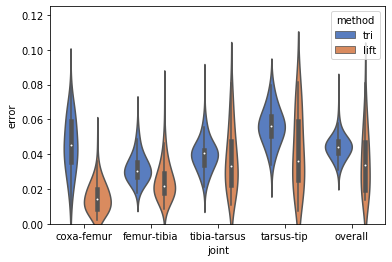

In [4]:
q = error.quantile(q=0.95)
error = error[error['error']<q[0]]
sns.violinplot(x="joint", y="error", hue="method", data=error, palette="muted",bw=0.7)
plt.ylim(0, 0.125)
#plt.savefig('tri_vs_lift.svg')

# Camera angle error

In [5]:
def read_convergence_info(file):
    f=open(file, "r")
    contents=f.readlines()
    epoch, lr, loss_train, loss_test, err_test = [], [], [], [], []
    for i in range(1,len(contents)):
        line = contents[i][:-1].split('\t')
        epoch.append(float(line[0]))
        lr.append(float(line[1]))
        loss_train.append(float(line[2]))
        loss_test.append(float(line[3]))
        err_test.append(float(line[4]))
        
    return epoch, lr, loss_train, loss_test, err_test

Convergence

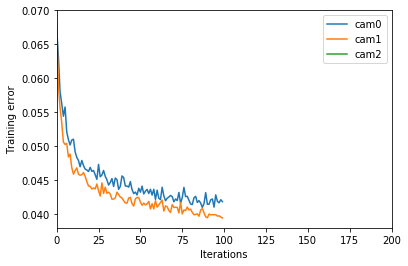

In [7]:
import matplotlib.pyplot as plt
from src.utils import filter_data
root_folder = '/data/LiftPose3D/fly_tether/cam_angles/'

for cam in ['cam0', 'cam1', 'cam2']:
    epoch, lr, loss_train, loss_test, err_test = read_convergence_info(root_folder + cam +'/log_train.txt')
    plt.plot(err_test,label=cam)
    
#plt.xscale('log')
plt.xlim([0, 200])
plt.ylabel('Training error')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('training_error.svg')

# Behaviors

In [23]:
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

root_dir = '/data/LiftPose3D/fly_tether/behaviors/'
train_dir = ['train_PR', 'train_MDN', 'train_aDN']
test_dir = ['test_PR', 'test_MDN', 'test_aDN']

ttl_err = []
for i in range(3):
    for j in range(3):
        path = os.path.join(root_dir, train_dir[i], test_dir[j])
        all_err = torch.load(path + '/test_results.pth.tar')['all_err']
        ttl_err.append(np.mean(all_err, axis=1))

ttl_err = pd.DataFrame(ttl_err)#.set_index(np.arange(len(ttl_err[0])))
ttl_err.columns.names = ['frame']
ttl_err.index = pd.MultiIndex.from_tuples([('train_PR', 'test_PR'), ('train_PR', 'test_MDN'), ('train_PR', 'test_aDN'), 
                                             ('train_MDN', 'test_PR'), ('train_MDN', 'test_MDN'), ('train_MDN', 'test_aDN'),
                                             ('train_aDN', 'test_PR'), ('train_aDN', 'test_MDN'), ('train_aDN', 'test_aDN')],
                                         names=['train', 'test'])

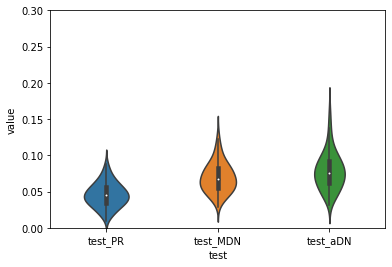

In [24]:
#train PR
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_PR',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.5, width=0.4)
plt.ylim(0, 0.3)
plt.grid(False)
#plt.savefig('train_PR.svg')

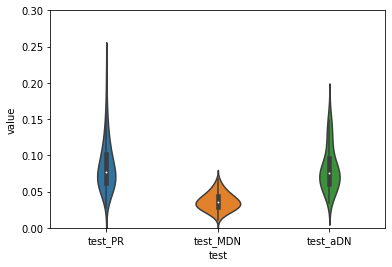

In [25]:
#train MDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_MDN',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.5, width=0.4)
plt.ylim(0, 0.3)
plt.grid(False)
#plt.savefig('train_MDN.svg')

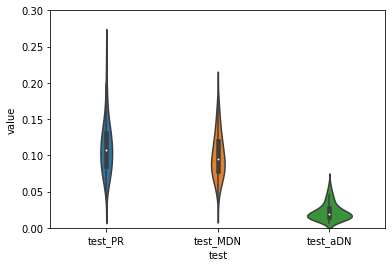

In [26]:
#train aDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_aDN',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.5, width=0.4)
plt.ylim(0, 0.3)
plt.grid(False)
#plt.savefig('train_aDN.svg')